In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import read_corpus, batch_iter, ind_to_one_hot

from vocab import Vocab, VocabEntry
from node_model import Node
import torch

from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, classification_report  

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/austinmurphy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/austinmurphy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)


def plot_subfigure(X, Y, subplot, title, transform):
    if transform == "pca":
        X = PCA(n_components=2).fit_transform(X)
    elif transform == "cca":
        X = CCA(n_components=2).fit(X, Y).transform(X)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

    classif = OneVsRestClassifier(SVC(kernel='linear'))
    classif.fit(X, Y)

    plt.subplot(2, 2, subplot)
    plt.title(title)

    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray', edgecolors=(0, 0, 0))
    plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                facecolors='none', linewidths=2, label='Class 1')
    plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                facecolors='none', linewidths=2, label='Class 2')

    plot_hyperplane(classif.estimators_[0], min_x, max_x, 'k--',
                    'Boundary\nfor class 1')
    plot_hyperplane(classif.estimators_[1], min_x, max_x, 'k-.',
                    'Boundary\nfor class 2')
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
    if subplot == 2:
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.legend(loc="upper left")




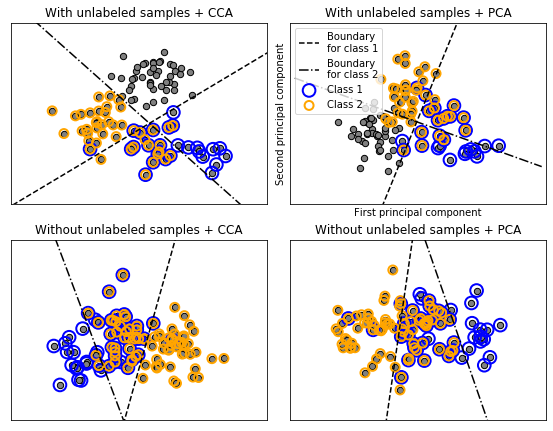

In [3]:
plt.figure(figsize=(8, 6))

X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                      allow_unlabeled=True,
                                      random_state=1)

plot_subfigure(X, Y, 1, "With unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 2, "With unlabeled samples + PCA", "pca")

X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                      allow_unlabeled=False,
                                      random_state=1)

plot_subfigure(X, Y, 3, "Without unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 4, "Without unlabeled samples + PCA", "pca")

plt.subplots_adjust(.04, .02, .97, .94, .09, .2)
plt.show()

## Reading in MIMIC Data

In [4]:
vocab = Vocab.load('vocab.json')

In [5]:
train_notes = read_corpus(file_path='./data/small/train_text.csv', column='text', sent_max_length=500, remove_stopwords=True)
train_labels = read_corpus(file_path='./data/small/train_labels.csv', column='labels', sent_max_length=500, remove_stopwords=True)

dev_notes = read_corpus(file_path='./data/small/dev_text.csv', column='text', sent_max_length=500, remove_stopwords=True)
dev_labels = read_corpus(file_path='./data/small/dev_labels.csv', column='labels', sent_max_length=500, remove_stopwords=True)

Processed 3301 lines.
Processed 3301 lines.
Processed 1101 lines.
Processed 1101 lines.


In [19]:
def text_to_indices(notes):
    source_padded = vocab.notes_.to_input_tensor(notes, device='cpu')
#     print(source_padded.shape)
    source_padded = np.swapaxes(source_padded.detach().numpy(), 0,1)
    print(source_padded.shape)
    return source_padded

train_notes_ids = text_to_indices(train_notes)
train_notes_ids

dev_notes_ids = text_to_indices(dev_notes)
dev_notes_ids

(3300, 500)
(1100, 500)


array([[  58,  134,   21, ...,    6, 1470, 1183],
       [  58,  134,   21, ..., 3627,    4, 5000],
       [  21,  912,   19, ...,    8, 1213,    4],
       ...,
       [  58,  134,   21, ...,    4,  332,  492],
       [  58,   21,  120, ...,    7,  112,  339],
       [  58,   21,    5, ...,  279,   32,    4]])

In [20]:
def labels_to_indices(labels):
    train_labels_np = ind_to_one_hot(labels, vocab.num_labels).detach().numpy()
    print(train_labels_np.shape)
    return train_labels_np
    
train_labels_np = labels_to_indices(train_labels)
train_labels_np

dev_labels_np = labels_to_indices(dev_labels)
dev_labels_np

(3300, 19)
(1100, 19)


array([[1., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [21]:
# train_notes_ids = train_notes_ids[:1000,:]
# train_labels_np = train_labels_np[:1000,:]

In [22]:
classif = OneVsRestClassifier(SVC(kernel='linear', verbose=True, max_iter=1e5))
classif.fit(train_notes_ids, train_labels_np)

[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM][LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='auto_deprecated',
                                  kernel='linear', max_iter=1000000.0,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=True),
                    n_jobs=None)

In [23]:
predictions = classif.predict(dev_notes_ids)
predictions.shape

(1100, 19)

In [24]:
def calc_f1_cr(labels, predictions):

    f1 = f1_score(y_true=labels, y_pred=predictions, 
                    pos_label=1, average='micro')
    print("calcualted val f1: ", f1)
    
    cr = classification_report(y_true=labels, y_pred=predictions, 
                               labels=None, target_names=None, 
                               sample_weight=None, digits=2, 
                               output_dict=False)
    print("******** Validation Report *********\n",cr)
    
calc_f1_cr(dev_labels_np, predictions)

calcualted val f1:  0.4895899950259362
******** Validation Report *********
               precision    recall  f1-score   support

           0       0.27      0.40      0.33       336
           1       0.09      0.05      0.07       178
           2       0.72      0.76      0.74       795
           3       0.42      0.45      0.44       422
           4       0.22      0.13      0.16       304
           5       0.31      0.21      0.25       357
           6       0.88      0.85      0.86       958
           7       0.49      0.52      0.51       562
           8       0.41      0.43      0.42       473
           9       0.48      0.49      0.49       536
          10       0.00      0.00      0.00         3
          11       0.17      0.11      0.13       129
          12       0.22      0.12      0.16       249
          13       0.03      0.05      0.04        42
          14       0.00      0.00      0.00         0
          15       0.38      0.33      0.35       394
    

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### with PCA

In [10]:
X = PCA(n_components=2).fit_transform(train_notes_ids)

In [ ]:
classif2 = OneVsRestClassifier(SVC(kernel='linear', verbose=True))
classif2.fit(X, train_labels_np)

[LibSVM]

In [ ]:
predictions = classif2.predict(dev_notes_ids)
predictions.shape

In [ ]:
calc_f1_cr(dev_labels_np, predictions)

In [ ]:
5

## Text BOW / SVM

In [68]:
temp_train_notes = []
for doc in train_notes:
    temp_train_notes.append(' '.join(doc))
temp_dev_notes = []
for doc in dev_notes:
    temp_dev_notes.append(' '.join(doc))

In [61]:
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(temp_train_notes)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [69]:
train_x_tfidf = tfidf_vect.transform(temp_train_notes)
dev_x_tfidf = tfidf_vect.transform(temp_dev_notes)

In [64]:
print(tfidf_vect.vocabulary_)

{'sex': 16525, 'service': 16494, 'trauma': 18737, 'history': 8946, 'present': 14313, 'illness': 9441, 'patient': 13416, 'dd': 4405, 'year': 20108, 'old': 12784, 'male': 11142, 'brought': 2181, 'emergency': 6688, 'department': 4844, 'following': 7862, 'motor': 11855, 'vehicle': 19442, 'accident': 131, 'car': 2434, 'hit': 8950, 'pole': 14024, 'got': 8356, 'initial': 9792, 'event': 7094, 'struck': 17486, 'another': 817, 'arrival': 1092, 'questionable': 14880, 'seat': 16309, 'belt': 1705, 'sign': 16670, 'versus': 19512, 'dark': 4212, 'ecchymosis': 6488, 'apparently': 972, 'combative': 3265, 'required': 15553, 'intubation': 10111, 'order': 12919, 'control': 3663, 'transferred': 18666, 'surgical': 17762, 'intensive': 9936, 'care': 2490, 'unit': 19134, 'stabilization': 17182, 'past': 13386, 'medical': 11371, 'none': 12451, 'review': 15781, 'systems': 17910, 'vitals': 19623, 'blood': 1931, 'pressure': 14337, 'palp': 13208, 'pulse': 14718, 'temperature': 18123, 'physical': 13773, 'examination':

In [67]:
print(train_x_tfidf)

  (0, 20108)	0.021912325368540906
  (0, 19900)	0.03680644583274122
  (0, 19856)	0.02191954789913495
  (0, 19623)	0.03500068881099108
  (0, 19512)	0.061882832809235316
  (0, 19442)	0.1608478694863648
  (0, 19206)	0.1504018389807052
  (0, 19134)	0.07164233200569554
  (0, 19106)	0.07331822981398735
  (0, 19000)	0.0677257954981797
  (0, 18737)	0.22829029838090645
  (0, 18666)	0.053675696286150196
  (0, 18523)	0.053440544279713224
  (0, 18471)	0.11515939041375053
  (0, 18428)	0.03425595859459671
  (0, 18423)	0.025818822184368238
  (0, 18330)	0.046057025184651164
  (0, 18322)	0.03420650954048153
  (0, 18250)	0.040498758054725185
  (0, 18142)	0.03576625965331939
  (0, 18123)	0.039956853809686846
  (0, 17929)	0.054174726342478226
  (0, 17910)	0.04386064448665245
  (0, 17762)	0.018482512070922694
  (0, 17663)	0.0588495783073655
  :	:
  (3299, 1349)	0.05124568300078013
  (3299, 1283)	0.04071019579020921
  (3299, 1239)	0.03132808881678397
  (3299, 1105)	0.03958595139883753
  (3299, 1075)	0.098869

In [70]:
classif = OneVsRestClassifier(SVC(kernel='linear', verbose=True, max_iter=1e4))
classif.fit(train_x_tfidf, train_labels_np)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


[LibSVM][LibSVM][LibSVM][LibSVM]

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='auto_deprecated',
                                  kernel='linear', max_iter=10000.0,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=True),
                    n_jobs=None)

In [72]:
predictions = classif.predict(dev_x_tfidf)
predictions.shape

(1100, 19)

In [73]:
def calc_f1_cr(labels, predictions):

    f1 = f1_score(y_true=labels, y_pred=predictions, 
                    pos_label=1, average='micro')
    print("calcualted val f1: ", f1)
    
    cr = classification_report(y_true=labels, y_pred=predictions, 
                               labels=None, target_names=None, 
                               sample_weight=None, digits=2, 
                               output_dict=False)
    print("******** Validation Report *********\n",cr)
    
calc_f1_cr(dev_labels_np, predictions)

calcualted val f1:  0.6824814670308231
******** Validation Report *********
               precision    recall  f1-score   support

           0       0.80      0.52      0.63       336
           1       0.88      0.46      0.60       178
           2       0.77      0.95      0.85       795
           3       0.68      0.53      0.60       422
           4       0.81      0.29      0.43       304
           5       0.75      0.34      0.47       357
           6       0.88      1.00      0.94       958
           7       0.76      0.72      0.74       562
           8       0.82      0.56      0.66       473
           9       0.72      0.70      0.71       536
          10       0.00      0.00      0.00         3
          11       0.80      0.06      0.12       129
          12       0.86      0.12      0.22       249
          13       0.00      0.00      0.00        42
          14       0.00      0.00      0.00         0
          15       0.60      0.41      0.49       394
    

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [75]:
from sklearn import naive_bayes

In [77]:
Naive = OneVsRestClassifier(naive_bayes.MultinomialNB())
Naive.fit(train_x_tfidf, train_labels_np)

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                            fit_prior=True),
                    n_jobs=None)

In [79]:
predictions_NB = Naive.predict(dev_x_tfidf)
predictions_NB.shape

(1100, 19)

In [80]:
calc_f1_cr(dev_labels_np, predictions_NB)

calcualted val f1:  0.5750666781381742
******** Validation Report *********
               precision    recall  f1-score   support

           0       1.00      0.02      0.05       336
           1       0.00      0.00      0.00       178
           2       0.72      1.00      0.84       795
           3       0.75      0.17      0.28       422
           4       1.00      0.01      0.02       304
           5       1.00      0.00      0.01       357
           6       0.87      1.00      0.93       958
           7       0.66      0.82      0.73       562
           8       0.90      0.28      0.43       473
           9       0.64      0.71      0.67       536
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00       129
          12       0.00      0.00      0.00       249
          13       0.00      0.00      0.00        42
          14       0.00      0.00      0.00         0
          15       0.77      0.03      0.05       394
    

/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/austinmurphy/opt/anaconda3/envs/attentionxml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
